In [ ]:
import tensorflow as tf
import numpy as np

# Dan is an engineer.

# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self, layers, lb, ub, alpha):
        """
        layers: list containing the number of neurons for each layer (input, hidden, output)
        lb: lower bound for x and t (e.g., np.array([x_min, t_min]))
        ub: upper bound for x and t (e.g., np.array([x_max, t_max]))
        alpha: diffusivity coefficient in the heat equation
        """
        super(PINN, self).__init__()
        self.lb = tf.convert_to_tensor(lb, dtype=tf.float32)
        self.ub = tf.convert_to_tensor(ub, dtype=tf.float32)
        self.alpha = alpha
        
        self.hidden_layers = []
        for width in layers[1:-1]:
            self.hidden_layers.append(tf.keras.layers.Dense(width, activation=tf.nn.tanh,
                                                              kernel_initializer='glorot_normal'))
        self.out_layer = tf.keras.layers.Dense(layers[-1], activation=None,
                                               kernel_initializer='glorot_normal')
    
    def call(self, X):
        # X is expected to be a tensor with shape (N, 2): [x, t]
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0  # feature scaling to [-1,1]
        for layer in self.hidden_layers:
            H = layer(H)
        u = self.out_layer(H)
        return u

    def pde_residual(self, X):
        """
        Computes the PDE residual: u_t - alpha*u_xx
        """
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(X)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(X)
                u = self.call(X)
            # X has two components: x and t
            u_x = tape1.gradient(u, X)[:, 0:1]  # derivative with respect to x
            u_t = tape1.gradient(u, X)[:, 1:2]  # derivative with respect to t
        u_xx = tape2.gradient(u_x, X)[:, 0:1]   # second derivative with respect to x
        del tape1, tape2

        # PDE: u_t - alpha * u_xx = 0
        f = u_t - self.alpha * u_xx
        return f

# Example usage:

# Domain bounds (e.g., x in [0,1], t in [0,1])
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])
alpha = 0.01  # thermal diffusivity

# Neural network architecture: 2 inputs, 3 hidden layers with 20 neurons each, 1 output.
layers = [2, 20, 20, 20, 1]

# Instantiate the model
pinn_model = PINN(layers, lb, ub, alpha)

# Define optimizers and loss functions
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step(X_collocation, X_data, u_data):
    """
    X_collocation: collocation points in the (x,t) domain where PDE residual is enforced.
    X_data: points with known u values (from initial and boundary conditions).
    u_data: corresponding u values.
    """
    with tf.GradientTape() as tape:
        # Compute PDE residual loss (physics loss)
        f = pinn_model.pde_residual(X_collocation)
        loss_f = tf.reduce_mean(tf.square(f))
        
        # Compute data loss for initial and boundary conditions
        u_pred = pinn_model(X_data)
        loss_data = tf.reduce_mean(tf.square(u_pred - u_data))

        # Optionally, you can add a boundary condition loss if needed
        # use Dirichlet boundary conditions
        l = X_data.shape[0]
        print(u_pred.shape)
        bc_loss = 0
        for i in range(len(X_data)):
            bc_loss += abs(u_pred[0] - u_pred[-1])
        print("value: ", bc_loss)
        
        # Total loss: weight factors can be tuned as needed.
        loss = loss_f + loss_data + bc_loss

    gradients = tape.gradient(loss, pinn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))
    return loss

# Example: Generate training data
# Collocation points in the domain for enforcing the PDE
N_collocation = 1000
X_collocation = np.random.rand(N_collocation, 2)  # random points in [0,1]x[0,1]

# Initial and boundary condition data points
# For example, initial condition: u(x,0) = sin(pi*x)
N_data = 200
x_data = np.linspace(0, 1, N_data)[:, None]
t_data = np.zeros_like(x_data)
X_data = np.hstack((x_data, t_data))
u_data = np.sin(np.pi * x_data)  # initial condition


# Training loop
epochs = 5000
for epoch in range(epochs):
    loss_value = train_step(tf.convert_to_tensor(X_collocation, dtype=tf.float32),
                              tf.convert_to_tensor(X_data, dtype=tf.float32),
                              tf.convert_to_tensor(u_data, dtype=tf.float32))
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# After training, you can use pinn_model.predict(...) to evaluate the solution.


(200, 1)
value:  Tensor("add_199:0", shape=(1,), dtype=float32)
(200, 1)
value:  Tensor("add_199:0", shape=(1,), dtype=float32)
Epoch 0, Loss: [201.69672]
Epoch 500, Loss: [0.94448614]
Epoch 1000, Loss: [1.0833688]
Epoch 1500, Loss: [0.14483376]
Epoch 2000, Loss: [0.50400794]
Epoch 2500, Loss: [0.6295922]
Epoch 3000, Loss: [1.8984627]
Epoch 3500, Loss: [0.1777637]
Epoch 4000, Loss: [0.9436247]
Epoch 4500, Loss: [0.57633984]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


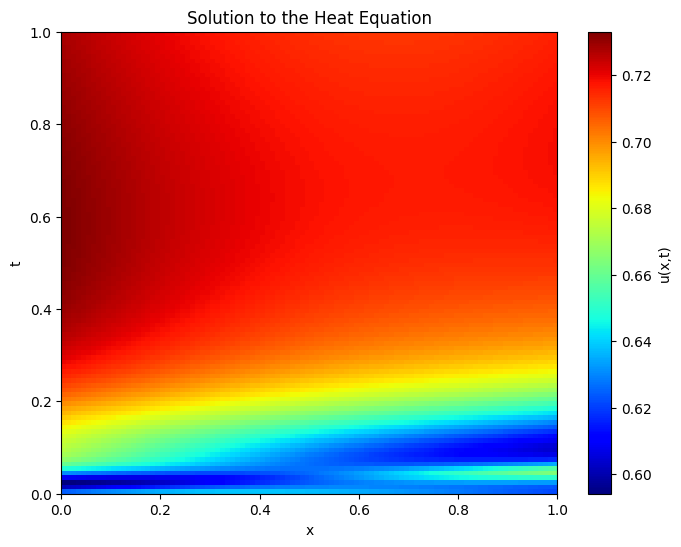

In [15]:
#plot the solution
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to evaluate the model (e.g., x in [0, 1] and t in [0, 1])
N_x = 100  # Number of x points
N_t = 100  # Number of t points

# Create the grid (x, t)
x = np.linspace(0, 1, N_x)[:, None]  # Shape (N_x, 1)
t = np.linspace(0, 20, N_t)[:, None]  # Shape (N_t, 1)
X_grid = np.hstack((np.tile(x, (N_t, 1)), np.repeat(t, N_x, axis=0)))  # Shape (N_x*N_t, 2)

# Predict the solution at these points
u_pred = pinn_model.predict(X_grid)

# Reshape the predictions for plotting (to make it 2D, reshape to (N_x, N_t))
u_pred = u_pred.reshape(N_t, N_x)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.imshow(u_pred, interpolation='nearest', cmap='jet', origin='lower', aspect='auto',
           extent=[0, 1, 0, 1])
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Heat Equation')
plt.show()